# GloFAS probabilistic

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [2]:
import os

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from src.utils import blob
from src.datasources import glofas
from src.constants import *

In [3]:
# glofas.process_reforecast_frac()

In [4]:
ref = glofas.load_reforecast_frac()

In [5]:
ref["time"].dt.year.nunique()

20

## Calculate reanalysis peaks

In [7]:
rp_a = 5

rea = glofas.load_reanalysis()
rea = rea[rea["time"].dt.year.isin(ref["time"].dt.year.unique())]
rea_peaks = rea.loc[rea.groupby(rea["time"].dt.year)["dis24"].idxmax()]
q = rea_peaks["dis24"].quantile(1 - 1 / rp_a)
rea_peaks["trigger"] = rea_peaks["dis24"] > q
rea_peaks["year"] = rea_peaks["time"].dt.year
rea_peaks["cerf"] = rea_peaks["year"].isin(CERF_YEARS)
rea_peaks["rank"] = rea_peaks["dis24"].rank(ascending=False)
rea_peaks["rp"] = len(rea_peaks) / rea_peaks["rank"]
rea_peaks = rea_peaks.sort_values("rank", ascending=False)

In [8]:
rea_peaks

,time,dis24,trigger,year,cerf,rank,rp
13411,2015-09-20,1563.8047,False,2015,False,20.0,1.000000
12658,2013-08-28,1611.9375,False,2013,True,19.0,1.052632
14113,2017-08-22,1717.8984,False,2017,False,18.0,1.111111
10127,2006-09-23,1733.7578,False,2006,False,17.0,1.176471
9381,2004-09-07,1856.5781,False,2004,False,16.0,1.250000
15248,2020-09-30,1946.8281,False,2020,False,15.0,1.333333
9723,2005-08-15,2077.3281,False,2005,False,14.0,1.428571
11205,2009-09-05,2169.9062,False,2009,False,13.0,1.538462
10491,2007-09-22,2235.7812,False,2007,False,12.0,1.666667
15530,2021-07-09,2253.2969,False,2021,False,11.0,1.818182


In [9]:
ref

,time,leadtime,valid_time,2yr_thresh,3yr_thresh,5yr_thresh
0,2003-07-03,1,2003-07-04,0.0,0.0,0.0
1,2003-07-03,2,2003-07-05,0.0,0.0,0.0
2,2003-07-03,3,2003-07-06,0.0,0.0,0.0
3,2003-07-03,4,2003-07-07,0.0,0.0,0.0
4,2003-07-03,5,2003-07-08,0.0,0.0,0.0
...,...,...,...,...,...,...
26455,2022-10-30,31,2022-11-30,0.0,0.0,0.0
26456,2022-10-30,32,2022-12-01,0.0,0.0,0.0
26457,2022-10-30,33,2022-12-02,0.0,0.0,0.0
26458,2022-10-30,34,2022-12-03,0.0,0.0,0.0


## Calculate reforecast peaks

Filtering by maximum leadtime

In [25]:
rp_f = 5
lt_min = 7

val_col = "5yr_thresh"

dfs = []

for lt in ref["leadtime"].unique():
    if lt < lt_min or lt > 30:
        continue

    dff = ref[(ref["leadtime"] <= lt) & (ref["leadtime"] >= lt_min)]
    df_in = dff.loc[dff.groupby(dff["time"].dt.year)[val_col].idxmax()]
    df_in["lt_max"] = lt
    thresh = df_in[val_col].quantile(1 - 1 / rp_f)
    df_in["trigger"] = df_in[val_col] >= thresh
    print(lt, thresh)
    dfs.append(df_in)

ref_peaks = pd.concat(dfs, ignore_index=True)
ref_peaks["year"] = ref_peaks["time"].dt.year

7 0.0
8 0.020000000000000108
9 0.1
10 0.1
11 0.1
12 0.1
13 0.1
14 0.1
15 0.1
16 0.1
17 0.1
18 0.1
19 0.1200000000000001
20 0.1200000000000001
21 0.1200000000000001
22 0.1200000000000001
23 0.1200000000000001
24 0.1200000000000001
25 0.1200000000000001
26 0.1200000000000001
27 0.1200000000000001
28 0.2
29 0.2
30 0.2


## Compare reanalysis to reforecast

### Calcuate TP/FP/TN/FN

In [26]:
compare = rea_peaks.merge(ref_peaks, on="year", suffixes=["_a", "_f"])
for indicator in ["cerf", "trigger_a"]:
    compare[f"TP_{indicator}"] = compare[indicator] & compare["trigger_f"]
    compare[f"FP_{indicator}"] = ~compare[indicator] & compare["trigger_f"]
    compare[f"TN_{indicator}"] = ~compare[indicator] & ~compare["trigger_f"]
    compare[f"FN_{indicator}"] = compare[indicator] & ~compare["trigger_f"]

compare = compare.sort_values(["year", "lt_max"])

### Calculate TPR etc metrics

In [27]:
dicts = []
for lt, group in compare.groupby("lt_max"):
    TPR = group["TP_trigger_a"].sum() / group["trigger_a"].sum()
    PPV = group["TP_trigger_a"].sum() / group["trigger_f"].sum()
    TPR_C = group["TP_cerf"].sum() / group["cerf"].sum()
    PPV_C = group["TP_cerf"].sum() / group["trigger_f"].sum()
    dicts.append(
        {"TPR": TPR, "PPV": PPV, "TPR_C": TPR_C, "PPV_C": PPV_C, "lt_max": lt}
    )

metrics = pd.DataFrame(dicts)
metrics

,TPR,PPV,TPR_C,PPV_C,lt_max
0,1.00,0.200000,1.000000,0.150000,7
1,0.50,0.500000,0.333333,0.250000,8
2,0.50,0.333333,0.333333,0.166667,9
3,0.75,0.375000,0.333333,0.125000,10
4,0.75,0.300000,0.333333,0.100000,11
5,1.00,0.333333,0.333333,0.083333,12
6,1.00,0.333333,0.333333,0.083333,13
7,1.00,0.307692,0.666667,0.153846,14
8,1.00,0.307692,0.666667,0.153846,15
9,1.00,0.307692,0.666667,0.153846,16


In [16]:
compare[compare["trigger_f"]].set_index("lt_max").loc[9]

,time_a,dis24,trigger_a,year,cerf,rank,rp,time_f,leadtime,valid_time,...,5yr_thresh,trigger_f,TP_cerf,FP_cerf,TN_cerf,FN_cerf,TP_trigger_a,FP_trigger_a,TN_trigger_a,FN_trigger_a
lt_max,,,,,,,,,,,,,,,,,,,,,
9,2003-09-19,3312.0156,True,2003,False,2.0,10.000000,2003-08-28,8,2003-09-05,...,0.1,True,False,True,False,False,True,False,False,False
9,2010-09-07,3109.2578,True,2010,False,4.0,5.000000,2010-09-07,7,2010-09-14,...,0.0,True,False,True,False,False,True,False,False,False
9,2012-08-21,3110.0781,True,2012,False,3.0,6.666667,2012-09-14,8,2012-09-22,...,0.0,True,False,True,False,False,True,False,False,False
9,2022-08-19,5347.1720,True,2022,True,1.0,20.000000,2022-08-31,7,2022-09-07,...,0.0,True,True,False,False,False,True,False,False,False


### Plot

For chosen max leadtime and return period

/var/folders/66/764yc5p92nvdc_nm3xmy5rn40000gn/T/ipykernel_18726/3984742773.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare_lt["percent"] = compare_lt[val_col] * 100


Text(0.5, 1.0, 'Benue river at Wuroboki\nGloFAS yearly peaks (2003-2022)')

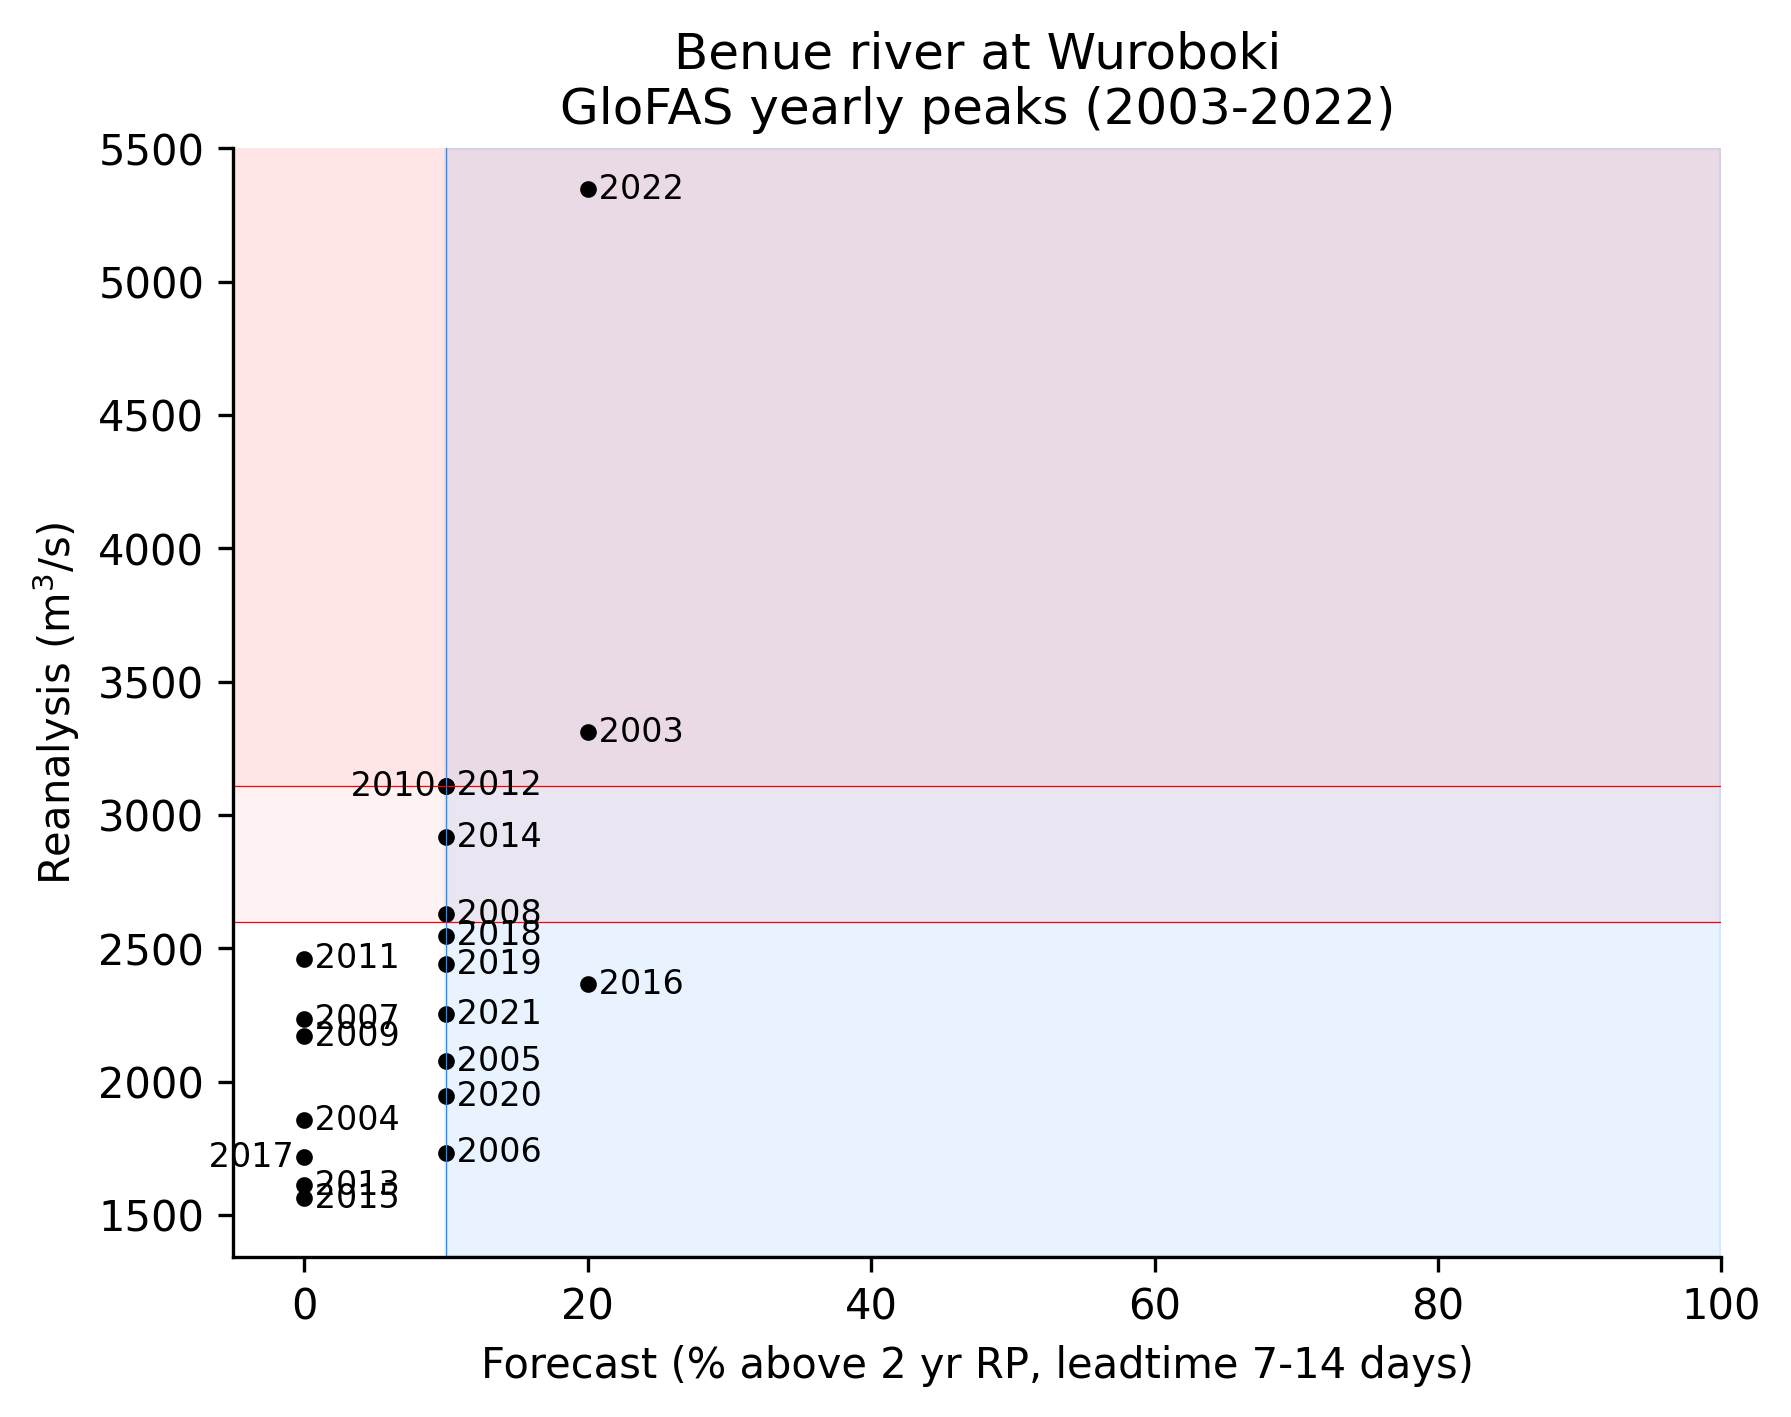

In [28]:
# 3yr
rp_a_3 = 2600
# 2yr
# rp_a_3 = 2364.7734
rp_a_5 = 3109
rp_f = 0.1 * 100
compare_lt = compare[compare["lt_max"] == 14]
compare_lt["percent"] = compare_lt[val_col] * 100
fig, ax = plt.subplots(dpi=300)
compare_lt.plot(
    y="dis24",
    x="percent",
    ax=ax,
    marker=".",
    color="k",
    linestyle="",
    legend=False,
)

ax.axvline(x=rp_f, color="dodgerblue", linestyle="-", linewidth=0.3)
ax.axvspan(
    rp_f,
    100,
    ymin=0,
    ymax=1,
    color="dodgerblue",
    alpha=0.1,
)

ax.axhline(y=rp_a_3, color="red", linestyle="-", linewidth=0.3)
ax.axhspan(
    rp_a_3,
    6000,
    color="red",
    alpha=0.05,
    linestyle="None",
)

ax.axhline(y=rp_a_5, color="red", linestyle="-", linewidth=0.3)
ax.axhspan(
    rp_a_5,
    6000,
    color="red",
    alpha=0.05,
    linestyle="None",
)

for year, row in compare_lt.set_index("year").iterrows():
    flip_years = [2017, 2010]
    ha = "right" if year in flip_years else "left"
    ax.annotate(
        f" {year} ",
        (row["percent"], row["dis24"]),
        color="k",
        fontsize=8,
        va="center",
        ha=ha,
    )

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel("Reanalysis (m$^3$/s)")
ax.set_xlabel(f"Forecast (% above 2 yr RP, leadtime {lt_min}-14 days)")
ax.set_ylim(top=5500)
ax.set_xlim(right=100)
ax.set_title("Benue river at Wuroboki\nGloFAS yearly peaks (2003-2022)")

In [22]:
(len(compare_lt) + 1) / 6

3.5

In [15]:
cols = ["year", "time_f", "leadtime"]
compare_lt[compare_lt["trigger_f"]][cols].rename(
    columns={
        "year": "Year",
        "time_f": "Trigger date",
        "leadtime": "Leadtime (days)",
    }
)

,Year,Trigger date,Leadtime (days)
439,2003,2003-08-28,8
391,2010,2010-09-07,7
415,2012,2012-09-04,13
367,2014,2014-08-28,12
247,2016,2016-09-18,8
319,2018,2018-09-04,10
271,2019,2019-08-31,10
463,2022,2022-08-31,7


In [17]:
dicts = []
for lt_max, group in compare.groupby("lt_max"):
    corr_in = group.corr()
    dicts.append(
        {
            "lt_max": lt_max,
            "2yr_thresh": corr_in.loc["dis24", "2yr_thresh"],
            "5yr_thresh": corr_in.loc["dis24", "5yr_thresh"],
        }
    )

df_corr = pd.DataFrame(dicts)
df_corr

,lt_max,2yr_thresh,5yr_thresh
0,7,0.737447,0.233224
1,8,0.720288,0.233224
2,9,0.708906,0.233224
3,10,0.668704,0.233224
4,11,0.667012,0.201172
5,12,0.669325,0.201172
6,13,0.641116,0.201172
7,14,0.653409,0.201172
8,15,0.622481,0.201172
9,16,0.625593,0.201172


<Axes: xlabel='lt_max'>

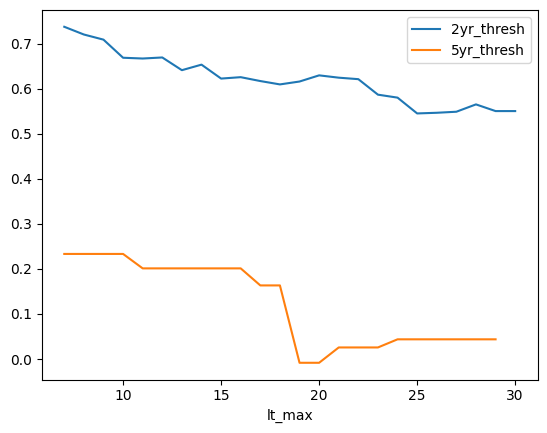

In [18]:
df_corr.set_index("lt_max").plot()